In [1]:
from __future__ import absolute_import, division, print_function
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from scipy.spatial.distance import cdist 
import numpy.matlib
import time
from scipy.stats import multivariate_normal
# from ModelSetup_banana import ModelSetup 
from ModelSetup_local_concentration_d import ModelSetup 
#np.random.seed(seed=5)
from SVN_H import SVN_H_New

In [2]:
model = ModelSetup()

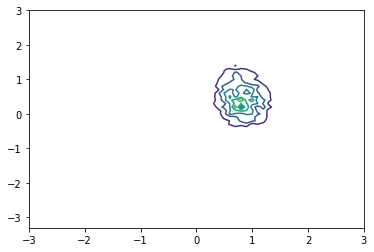

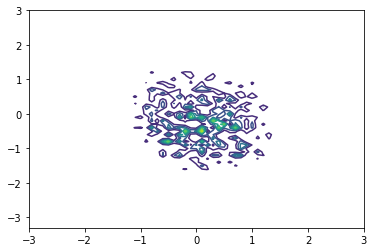

In [3]:
x1 = np.arange(-3,3.05,.1)
x2 = np.arange(-3.3,3.05,.1)
X1,X2 = np.meshgrid(x1, x2)
x_2d = np.array([X1.flatten('F'),X2.flatten('F')])
post_pdf =  model.postdcontour(x_2d,np.array([0,1]),50)
post_pdf = np.reshape(post_pdf, (x2.shape[0], x1.shape[0]),order="F")
plt.contour(X1, X2, post_pdf)
plt.show()
post_pdf2 =  model.postdcontour(x_2d,np.array([2,3]),50)
post_pdf2 = np.reshape(post_pdf2, (x2.shape[0], x1.shape[0]),order="F")
plt.contour(X1, X2, post_pdf2)
plt.show()

In [13]:
N = 1000
model.n = model.dim
random_sample = np.random.randn(model.dim,N)
x0 = model.prior_m + np.dot(model.prior_C0sqrt,random_sample) 

In [ ]:
itermax = 10
stepsize = 1
x = x0.copy()
x, stepsize, timeave = SVN_H_New(x, stepsize, itermax, model,tol0=1e-4,maxiter0=50)
print(timeave)
plt.contour(X1, X2, post_pdf)
plt.plot(x[0,:],  x[1,:], 'g.', 5)
plt.xlim([-2,3])
plt.ylim([-2,3])

In [ ]:
np.sum(kernel)

In [5]:
    itermax = 10
    stepsize = 1
    x = x0.copy()
    N = x.shape[1]
    
    # Initialise particle maximum shifts
    maxshift = np.zeros(N)
    maxmaxshift_old = np.inf
    
    # Initialise average computational time
    timeave = 0;
    
    # Identity matrix
    I = np.identity(model.n)
    #print('   step norm        mean           min            median' )
    log_posterior = np.zeros(N)
    for k in range(itermax):
        tic = time.time()
        
        g_mlpt = np.zeros((model.n, N))
        gnH = np.zeros((model.n,model.n,N))
        
        for j in range(N):
            Fx,J = model.fwd_solve(x[:,[j]])
            g_mlpt[:,[j]] = model.grad_mlpt(x[:,[j]], Fx, J)
            gnH[:,:,j]  = model.prior_C0i + model.obs_nobs*np.dot(J,J.transpose()) / model.obs_std2
        
        # Averaging Hessian approximation
        sEH = np.mean(gnH,axis=2) / model.n * N * np.sqrt(N)
        
        x_copy = x.copy()
        Q = np.zeros( (model.n, N) )
#         kernel = np.zeros((N,N))
#         gkernel = np.zeros((N,N,model.n))
#         for i in range(N):
#             sign_diff = x[:,i,np.newaxis] - x_copy
#             Msd   = np.matmul(sEH, sign_diff)
#             kernel[i,:]  = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
#             gkernel[i,:,:] = (Msd * kernel[i,:]).T
#         sum_k = 1. #np.sum(kernel,axis=1)
#         sum_gkernel = np.sum(gkernel,axis = 0)/np.sum(kernel,axis=1)[:,np.newaxis]
        for i in range(N):
            sign_diff = x[:,i,np.newaxis] - x_copy
            Msd   = np.matmul(sEH, sign_diff)
            kern  = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
            gkern = Msd * kern            
#             kern  = kernel[i,:]#np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
#             gkern = gkernel[i,:,:].T #Msd * kern

            mgJ = np.mean(- g_mlpt * kern + gkern , 1)
            HJ  = np.mean(gnH * kern ** 2, 2) + np.matmul(gkern, gkern.T) /N
#             HJ  = np.mean(gnH * kern * sum_k, 2) + np.matmul(gkern, sum_gkernel) /N
            Q[:,i] = np.linalg.solve(HJ, mgJ)
            maxshift[i] = np.linalg.norm(Q[:,i], np.inf)
#             x[:,i] += stepsize * Q[:,i]
#             log_posterior[i] = model.log_post(x[:,[i]])
            
            
            
        for i in range(N):
            step = 0.
            sign_diff = x[:,i,np.newaxis] - x
            Msd   = np.matmul(sEH, sign_diff)
            kern = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
            for j in range(N):
                step +=Q[:,j] *kern[j]#/np.sum(kern)
                
            x[:,i] += step# /np.sum(kernel,axis=1)[i]
            log_posterior[i] = model.log_post(x[:,[i]])
            
#             x[:,i] += stepsize * Q[:,i]
#             log_posterior[i] = model.log_post(x[:,[i]])

#         g_kern = np.zeros((N,N,model.n))
#         for i in range(N):
#             sign_diff = x[:,[i]] - x_copy
#             kern[i,:] = np.exp(-0.5*np.sum((np.dot(sign_diff.transpose(),sEH)*sign_diff.transpose()), axis = 1))
#             g_kern[i,:,:] = np.transpose((np.dot(sEH,sign_diff) * kern[i,:]),(1,0))
        
#         sum_kern = np.sum(kern,axis = 1)#=/np.float(N)
#         sum_g_kern = np.sum(g_kern,axis = 0) / np.tile(sum_kern[:,np.newaxis],[1,model.n])
        
#         log_posterior = np.zeros(N)
#         for i in range(N):
            
#             kern_tmp = kern[i,:]*sum_kern
            
#             g_kern_i = np.transpose(g_kern[i,:,:],(1,0))
            
#             mgrad_J = np.mean( -kern[i,:] * g_mlpt + g_kern_i, axis=1)
            

#             kern_i = kern[i,:]
#             H_J = np.mean(gnH * kern_tmp, 2) + np.matmul(g_kern_i, g_kern_i.T) / N
# #             H_J = np.mean( np.transpose( np.tile(kern[i,:][:,np.newaxis],[model.n,1,model.n]), (0, 2, 1)  ) * gnH , axis=2 ) + np.mean(np.tile(sum_g_kern.transpose()[:,np.newaxis,:],[1,model.n,1])*np.tile(g_kern_i[np.newaxis,:,:],[model.n,1,1]), axis = 2)
# #             Q,info = scipy.sparse.linalg.gmres(H_J, mgrad_J,tol=tol0,maxiter=maxiter0)
#             Q = np.linalg.solve(H_J, mgrad_J)
        
            
#             x[:,i] = x[:,i] + stepsize*Q
#             log_posterior[i] = model.log_post(x[:,[i]])
            
#             maxshift[i] = np.linalg.norm(Q, np.inf)
 
        maxmaxshift = np.max(maxshift);
        #print('Maximum shift is', maxmaxshift)
        
        
        
        print(k,np.linalg.norm(Q),np.mean(log_posterior))
        #print(k,np.linalg.norm(Q),np.mean(log_posterior),log_posterior.min(),np.median(log_posterior))
        
        if np.isnan(maxmaxshift) or maxmaxshift > 1e50:
            stepsize = 0.1*stepsize
            print('Step size too large; scaling it by factor 10.\n epsilon = ', stepsize)
            print('Reset particles... \n')
            x = model.prior_m + np.dot(model.prior_C0sqrt,np.random.randn(model.n,N))
        
        # Update stepsize
        if maxmaxshift >= maxmaxshift_old:
            stepsize = 0.9*stepsize
        elif np.abs(maxmaxshift - maxmaxshift_old) < 1e-6:
            stepsize = 1.01*stepsize
    
        maxmaxshift_old = maxmaxshift
        
        # Last iteration
        if k == itermax:
            print('Maximum number of iterations has been reached.\n')
    timeave += time.time() - tic

    timeave = timeave / itermax;

0 42.100268882797764 -18.08682149965723
1 26.449777938563603 -23.358307850808018
2 25.166678181596556 -21.990804614234147
3 33.027703722512754 -13.71310450760069
4 25.149900528486548 -20.9123153023283
5 28.120641276871034 -20.587626698583144
6 31.52872846526141 -20.463197645888197
7 30.210707794103637 -17.37307157054867
8 24.941313750209805 -16.47824695476788
9 25.885481860456245 -18.030616751543754


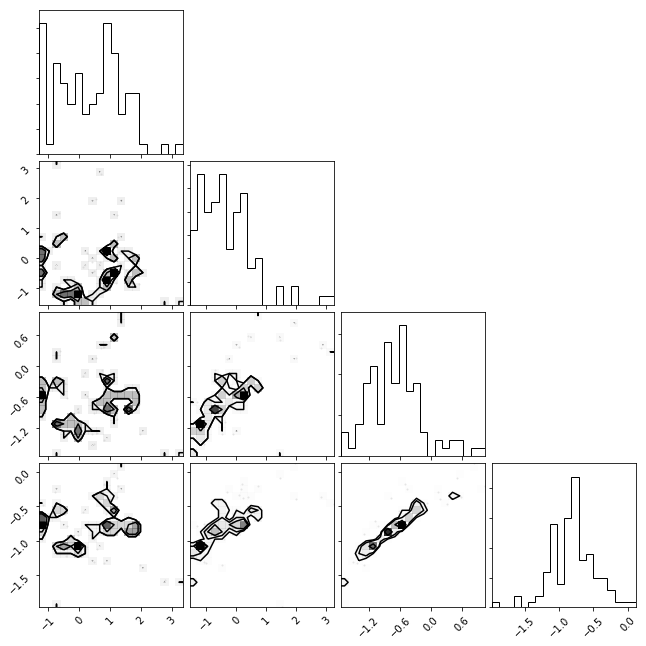

In [8]:
import corner
figure = corner.corner(x.T)

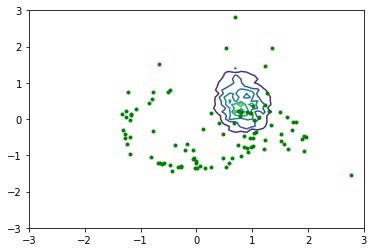

(-3, 3)

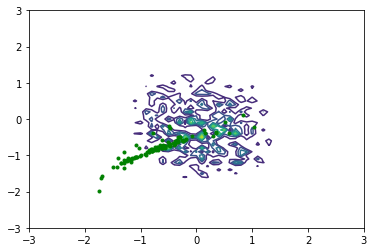

In [9]:
plt.contour(X1, X2, post_pdf)
plt.plot(x[0,:],  x[1,:], 'g.', 5)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()
plt.contour(X1, X2, post_pdf2)
plt.plot(x[2,:],  x[3,:], 'g.', 5)
plt.xlim([-3,3])
plt.ylim([-3,3])

In [14]:
    itermax = 10
    stepsize = 1
    x = x0.copy()
    N = x.shape[1]
    
    # Initialise particle maximum shifts
    maxshift = np.zeros(N)
    maxmaxshift_old = np.inf
    
    # Initialise average computational time
    timeave = 0;
    
    # Identity matrix
    I = np.identity(model.n)
    #print('   step norm        mean           min            median' )
    log_posterior = np.zeros(N)
    for k in range(itermax):
        tic = time.time()
        
        g_mlpt = np.zeros((model.n, N))
        gnH = np.zeros((model.n,model.n,N))
        
        for j in range(N):
            Fx,J = model.fwd_solve(x[:,[j]])
            g_mlpt[:,[j]] = model.grad_mlpt(x[:,[j]], Fx, J)
            gnH[:,:,j]  = model.prior_C0i + model.obs_nobs*np.dot(J,J.transpose()) / model.obs_std2
        
        # Averaging Hessian approximation
        sEH = np.mean(gnH,axis=2)  / model.n
        
        x_copy = x.copy()
        Q = np.zeros( (model.n, N) )
        kernel = np.zeros((N,N))
        gkernel = np.zeros((N,N,model.n))
        for i in range(N):
            sign_diff = x[:,i,np.newaxis] - x_copy
            Msd   = np.matmul(sEH, sign_diff)
            kernel[i,:]  = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
            gkernel[i,:,:] = (Msd * kernel[i,:]).T
        sum_k = 1.#np.sum(kernel,axis=1)
        sum_gkernel = np.sum(gkernel,axis = 0)/np.sum(kernel,axis=1)[:,np.newaxis]
        for i in range(N):
#             sign_diff = x[:,i,np.newaxis] - x_copy
#             Msd   = np.matmul(sEH, sign_diff)
#             kern  = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
#             gkern = Msd * kern            
            kern  = kernel[i,:]#np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
            gkern = gkernel[i,:,:].T #Msd * kern

            mgJ = np.mean(- g_mlpt * kern + gkern , 1)
#             HJ  = np.mean(gnH * kern ** 2, 2) + np.matmul(gkern, gkern.T) /N
            HJ  = np.mean(gnH * kern * sum_k, 2) + np.matmul(gkern, sum_gkernel) /N
            Q[:,i] = np.linalg.solve(HJ, mgJ)
            maxshift[i] = np.linalg.norm(Q[:,i], np.inf)
#             x[:,i] += stepsize * Q[:,i]
#             log_posterior[i] = model.log_post(x[:,[i]])
            
            
            
        for i in range(N):
            step = 0.
            sign_diff = x[:,i,np.newaxis] - x
            Msd   = np.matmul(sEH, sign_diff)
            kern = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
            for j in range(N):
                step +=Q[:,j] *kern[j]#/np.sum(kern)
                
            x[:,i] += step /np.sum(kernel,axis=1)[i]
            log_posterior[i] = model.log_post(x[:,[i]])
            
#             x[:,i] += stepsize * Q[:,i]
#             log_posterior[i] = model.log_post(x[:,[i]])

#         g_kern = np.zeros((N,N,model.n))
#         for i in range(N):
#             sign_diff = x[:,[i]] - x_copy
#             kern[i,:] = np.exp(-0.5*np.sum((np.dot(sign_diff.transpose(),sEH)*sign_diff.transpose()), axis = 1))
#             g_kern[i,:,:] = np.transpose((np.dot(sEH,sign_diff) * kern[i,:]),(1,0))
        
#         sum_kern = np.sum(kern,axis = 1)#=/np.float(N)
#         sum_g_kern = np.sum(g_kern,axis = 0) / np.tile(sum_kern[:,np.newaxis],[1,model.n])
        
#         log_posterior = np.zeros(N)
#         for i in range(N):
            
#             kern_tmp = kern[i,:]*sum_kern
            
#             g_kern_i = np.transpose(g_kern[i,:,:],(1,0))
            
#             mgrad_J = np.mean( -kern[i,:] * g_mlpt + g_kern_i, axis=1)
            

#             kern_i = kern[i,:]
#             H_J = np.mean(gnH * kern_tmp, 2) + np.matmul(g_kern_i, g_kern_i.T) / N
# #             H_J = np.mean( np.transpose( np.tile(kern[i,:][:,np.newaxis],[model.n,1,model.n]), (0, 2, 1)  ) * gnH , axis=2 ) + np.mean(np.tile(sum_g_kern.transpose()[:,np.newaxis,:],[1,model.n,1])*np.tile(g_kern_i[np.newaxis,:,:],[model.n,1,1]), axis = 2)
# #             Q,info = scipy.sparse.linalg.gmres(H_J, mgrad_J,tol=tol0,maxiter=maxiter0)
#             Q = np.linalg.solve(H_J, mgrad_J)
        
            
#             x[:,i] = x[:,i] + stepsize*Q
#             log_posterior[i] = model.log_post(x[:,[i]])
            
#             maxshift[i] = np.linalg.norm(Q, np.inf)
 
        maxmaxshift = np.max(maxshift);
        #print('Maximum shift is', maxmaxshift)
        
        
        
        print(k,np.linalg.norm(Q),np.mean(log_posterior))
        #print(k,np.linalg.norm(Q),np.mean(log_posterior),log_posterior.min(),np.median(log_posterior))
        
        if np.isnan(maxmaxshift) or maxmaxshift > 1e50:
            stepsize = 0.1*stepsize
            print('Step size too large; scaling it by factor 10.\n epsilon = ', stepsize)
            print('Reset particles... \n')
            x = model.prior_m + np.dot(model.prior_C0sqrt,np.random.randn(model.n,N))
        
        # Update stepsize
        if maxmaxshift >= maxmaxshift_old:
            stepsize = 0.9*stepsize
        elif np.abs(maxmaxshift - maxmaxshift_old) < 1e-6:
            stepsize = 1.01*stepsize
    
        maxmaxshift_old = maxmaxshift
        
        # Last iteration
        if k == itermax:
            print('Maximum number of iterations has been reached.\n')
    timeave += time.time() - tic

    timeave = timeave / itermax;

0 1078.175592837703 -73.20022291464534
1 327.30443412661015 -23.641725035931113
2 283.55555742271923 -15.171720333206649
3 983.3739103035361 -128.73253796378387
4 529.8695743887705 -31.520724767989183
5 342.7138682145239 -17.319411995294818
6 163.82381397573664 -6.413339340307291
7 54.11964281458982 -6.0091002226272945
8 39.37421962008595 -5.851520964878587
9 36.121815603104174 -5.7888649777053125


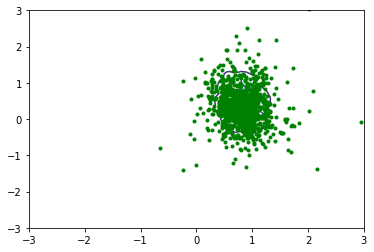

(-3, 3)

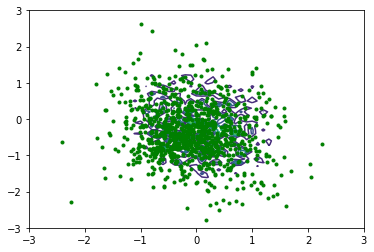

In [15]:
plt.contour(X1, X2, post_pdf)
plt.plot(x[0,:],  x[1,:], 'g.', 5)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()
plt.contour(X1, X2, post_pdf2)
plt.plot(x[2,:],  x[3,:], 'g.', 5)
plt.xlim([-3,3])
plt.ylim([-3,3])

In [17]:
x.shape

(4, 1000)

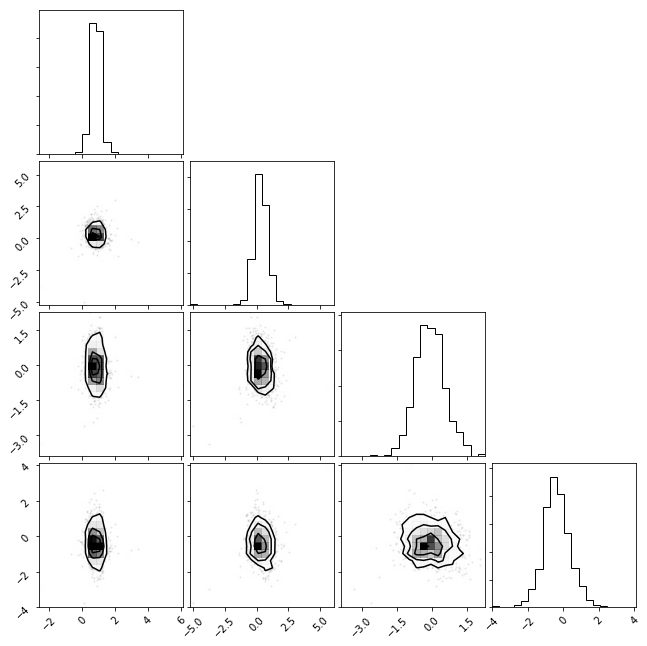

In [16]:
figure = corner.corner(x.T)

In [ ]:
from SVN_H_2 import SVN_H as SVN
itermax = 30
stepsize = 1
x = x0.copy()
model.n = model.dim
x, stepsize, timeave = SVN(x, stepsize, itermax, model)
print(timeave)

In [ ]:
plt.contour(X1, X2, post_pdf)
plt.plot(x[0,:],  x[1,:], 'g.', 5)
plt.xlim([-3,3])
plt.ylim([-3,3])

In [ ]:
from SVN_H_2 import SVN_H as SVN

In [ ]:
from SVN_H_2 import SVN_H as SVN
itermax = 10
stepsize = 1
x = x0.copy()
model.n = model.dim
x, stepsize, timeave = SVN(x, stepsize, itermax, model)
plt.contour(X1, X2, post_pdf)
plt.plot(x[0,:],  x[1,:], 'g.', 5)
# plt.xlim([-3,3])
# plt.ylim([-3,3])